In [9]:
import sys
sys.path.append('..')
import data_utils
sys.path.append(data_utils.join_base_path('reallaborai4u/preprocessing'))
from feature_names import NON_CONDITIONAL_FEAT as LABELS
from feature_names import INTERACTIVE_NAMES, INTERVENTION_NAMES_EN
PRINT_LABELS = [l.removeprefix('EMA_') for l in LABELS]

When is the last timepoint after which we see all 8 EMI?

[140.5 178.  208.5]


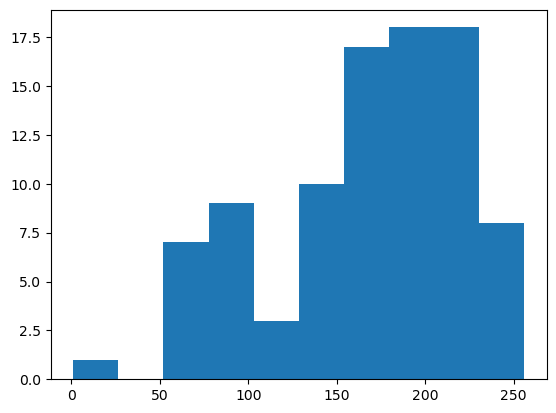

In [10]:
import data_utils
import matplotlib.pyplot as plt
import numpy as np

def get_last_idx_where_all_tasks_present(df):
    unique_tasks = set(INTERACTIVE_NAMES)
    idx = df.index[0]
    while set(df.loc[idx:, 'Task']) >= unique_tasks:
        idx += 1
    if idx > df.index[0]:
        return idx.item() - 1
    else:
        return np.nan

MRT = [2,3]
last_idx = []

for mrt in MRT:
    dir = data_utils.dataset_path(mrt, 'processed_csv_no_con')
    for p, df in data_utils.zip_participants_data(dir):
        last_idx.append(get_last_idx_where_all_tasks_present(df))

last_idx = np.array(last_idx)
median_last_idx = np.nanmedian(last_idx)
# print(last_idx)
plt.hist(last_idx)
print(np.quantile(last_idx[~np.isnan(last_idx)], [0.25, 0.5, 0.75]))
        

Find the proximal effects of each intervention on each EMA, and additionally the number of missings

In [20]:
import pandas as pd
import numpy as np
import glob
from typing import Optional
import os
import sys
sys.path.append('..')
import data_utils

def get_proximal_effects(data: pd.DataFrame, from_timestep: Optional[int]=None, until_timestep: Optional[int]=None,
                         sum_over_emas: bool=True, binned_policy: str='ignore'):
    
    if binned_policy == 'ignore':
        data.loc[data['Form'] == 'binned', LABELS] = np.nan
    elif binned_policy == 'drop':
        data = data.loc[data['Form'] != 'binned']
    diff = data.set_index(['Participant'], append=True)
    diff = data[LABELS].diff().shift(-1)
    diff[INTERACTIVE_NAMES] = data[INTERACTIVE_NAMES]
    diff = diff.dropna()
    diff = diff.loc[diff[INTERACTIVE_NAMES].sum(axis=1)>0]
    if from_timestep is not None:
        diff = diff.loc[from_timestep:]
    if until_timestep is not None:
        diff = diff.loc[:until_timestep]
    EMI_occurrence = diff[INTERACTIVE_NAMES].sum()
    EMI_occurrence[EMI_occurrence==0] = 1
    # Get the sum of effects of each intervention on each EMA
    sum_effects = diff[LABELS].T.dot(diff[INTERACTIVE_NAMES])
    # Normalize them by the number of intervention presentations
    sum_effects = sum_effects.div(EMI_occurrence)
    if sum_over_emas:
        sum_effects = sum_effects.sum()
    return sum_effects

Only take the effects of subjects whose "last idx where all EMI are present" is >= median (178)

In [21]:
import sys
sys.path.append('..')
from tqdm import tqdm
import torch as tc
import pandas as pd
import eval_reallabor_utils
import data_utils
import utils
from plotting_styles import PaperStyle
from bptt.plrnn import PLRNN

MRT = [2, 3]
effects = []

for mrt in MRT:

    mrt_effects = []
    test_data_dir = data_utils.dataset_path(mrt, 'processed_csv_no_con')
    data_files = data_utils.get_data_files(test_data_dir)
    participants = data_utils.get_participant_ids(data_files)
    dist = {}
    for p, df in tqdm(data_utils.zip_participants_data(test_data_dir), total=len(participants), desc=f'Calculating Impulse Responses for MRT {mrt}'):
        last_idx_where_all_tasks_present = get_last_idx_where_all_tasks_present(df)
        if last_idx_where_all_tasks_present < median_last_idx:  # median split participants for last index where all tasks are present
            continue
        participant_effects = []
        for binned_policy in ['ignore', 'drop', 'none']:        
            participant_effects.append(get_proximal_effects(df, binned_policy=binned_policy, from_timestep=last_idx_where_all_tasks_present))
        participant_effects = pd.concat(participant_effects, axis=1, keys=['ignore', 'drop', 'none'], names=['binned_policy']).T
        participant_effects['participant'] = p
        mrt_effects.append(participant_effects)
    mrt_effects = pd.concat(mrt_effects, axis=0).set_index('participant', append=True)
    effects.append(mrt_effects)
effects = pd.concat(effects, axis=0, keys=MRT, names=['MRT']).sort_index()

Calculating Impulse Responses for MRT 3: 100%|██████████| 59/59 [00:01<00:00, 47.43it/s]


Load models and predict the proximal effects 
- for every time step
    - with newest model
    - with all the models
- for every time step where there was an intervention
    - with newest model
    - with all the models
- for x0=unit vectors and null
    - with newest model
    - with all the models

- for every time step in the test set
    - for current model

In [16]:
import sys
sys.path.append('..')
from tqdm import tqdm
import torch as tc
import pandas as pd
import eval_reallabor_utils
import data_utils
import utils
from bptt.plrnn import PLRNN
from comparison_models.simple_models.models import KalmanFilter, VAR1

MRT = [2, 3]
plrnn_emi_cir = []
ModelClass = PLRNN

for mrt in MRT:

    mrt_cir = []

    results_dir = data_utils.join_ordinal_bptt_path('results', f'v2_MRT{mrt}_every_day_x6')
    test_data_dir = data_utils.dataset_path(mrt, 'processed_csv_no_con')

    models = eval_reallabor_utils.ModelCatalogue(results_dir)
    data_files = data_utils.get_data_files(test_data_dir)
    participants = data_utils.get_participant_ids(data_files)
    dist = {}
    for p, df in tqdm(data_utils.zip_participants_data(test_data_dir), total=len(participants), desc=f'Calculating Impulse Responses for MRT {mrt}'):
        last_idx_where_all_tasks_present = get_last_idx_where_all_tasks_present(df)
        if last_idx_where_all_tasks_present < np.median(last_idx):  # median split participants for last index where all tasks are present
            continue
        model_dirs = models.get_best_model_dirs(p)
        participant_cir = []
        for model_dir in model_dirs:
            model_cir = []
            args = utils.load_args(model_dir)
            if float(args['train_on_data_until_timestep']) > last_idx_where_all_tasks_present: # skip models trained on data after the last index where all tasks are present
                continue
            model = ModelClass(args)
            model.init_from_model_path(model_dir)
            dim_x, dim_s = args['dim_x'], args['dim_s']
            
            for x0 in [tc.tensor(df[LABELS].to_numpy()).float(),
                        tc.tensor(df.loc[df[INTERACTIVE_NAMES].sum(axis=1)>0, LABELS].to_numpy()).float(),
                        tc.cat((tc.eye(dim_x).float(), tc.zeros(dim_x).float().unsqueeze(0)), 0)]:
                cir = tc.zeros(dim_s)
                for i in range(dim_s):
                    perturbation = tc.zeros(dim_s).float()
                    perturbation[i] = 1
                    cir[i] = tc.nanmean(eval_reallabor_utils.impulse_response(model, perturbation, 1, cumulative=True, relative=False, x0=x0))
                model_cir.append(cir.detach().numpy())
            model_cir = pd.DataFrame(model_cir, columns=INTERACTIVE_NAMES, index=['all', 'emi', 'unit'])
            model_cir['timestep'] = int(float(args['train_on_data_until_timestep']))
            model_cir.index.name = 'x0'
            participant_cir.append(model_cir)
        if len(participant_cir) > 0:
            participant_cir_df = pd.concat(participant_cir, axis=0)            
            participant_cir_df = pd.concat([participant_cir_df.groupby('x0').mean(numeric_only=True),            # Mean over all models
                                            participant_cir_df.loc[participant_cir_df['timestep']==participant_cir_df['timestep'].max()]],  # just the last model
                                            axis=0, keys=['all', 'last'], names=['model'])
            participant_cir_df['participant'] = int(p)
            participant_cir_df = participant_cir_df.set_index(['participant'], append=True)[INTERACTIVE_NAMES]
            mrt_cir.append(participant_cir_df)
    mrt_cir = pd.concat(mrt_cir, axis=0)
    plrnn_emi_cir.append(mrt_cir)
plrnn_emi_cir = pd.concat(plrnn_emi_cir, axis=0, keys=MRT, names=['MRT']).sort_index()

Calculating Impulse Responses for MRT 3: 100%|██████████| 59/59 [00:51<00:00,  1.14it/s]


Check which configuration of models, x0, and binned_policies yields most beautiful result

In [22]:
corr_df = []

for mrt in MRT:

    for (model, x0), plrnn_emi_cir_group in plrnn_emi_cir.loc[mrt].groupby(['model', 'x0']):
        for binned_policy, effects_group in effects.loc[mrt].groupby('binned_policy'):          
            correlations = plrnn_emi_cir_group.droplevel(['model', 'x0']).corrwith(effects_group.droplevel('binned_policy'), axis=1, method='kendall')
            corr_se = pd.Series(index=['mean','median','>0','max','mrt','model','x0','binned_policy'],
                                data=[correlations.mean(), correlations.median(), (correlations>0).mean(), correlations.max(), mrt, model, x0, binned_policy])
            corr_df.append(corr_se)
corr_df = pd.concat(corr_df, axis=1).T

In [23]:
corr_df.sort_values('mean')

,mean,median,>0,max,mrt,model,x0,binned_policy
24,-0.086832,-0.071429,0.155172,0.357143,3,all,unit,drop
21,-0.086832,-0.071429,0.155172,0.357143,3,all,emi,drop
18,-0.086832,-0.071429,0.155172,0.357143,3,all,all,drop
15,-0.06293,-0.053899,0.12963,0.428571,2,last,unit,drop
12,-0.06293,-0.053899,0.12963,0.428571,2,last,emi,drop
9,-0.06293,-0.053899,0.12963,0.428571,2,last,all,drop
17,-0.036818,0.0,0.185185,0.428571,2,last,unit,none
16,-0.036818,0.0,0.185185,0.428571,2,last,unit,ignore
14,-0.036818,0.0,0.185185,0.428571,2,last,emi,none
13,-0.036818,0.0,0.185185,0.428571,2,last,emi,ignore


Fazit: x0 hat gar keinen Einfluss, all > last, binned_polcy should be 'ignore'

In [24]:
x0 = 'all'
model = 'last'
binned_policy = 'ignore'

Plot rank correlations

In [34]:
set(effects_rank.index).difference(set(plrnn_emi_rank.index))

{52}

Dropped [27, 63, 72, 73, 74, 79, 80, 82, 102, 104, 14, 16, 18, 19, 21, 22, 25, 31, 34, 42, 43, 52, 55, 56, 61, 66, 67, 68, 69, 70, 78, 101]
MRT2, percent >0: 18.51851851851852
Dropped [209, 216, 224, 226, 229, 231, 233, 237, 243, 254, 257, 264, 266, 269, 301, 206, 211, 212, 214, 215, 227, 228, 230, 234, 238, 242, 247, 256, 258, 259, 260, 262, 263, 265, 267, 271]
MRT3, percent >0: 17.24137931034483


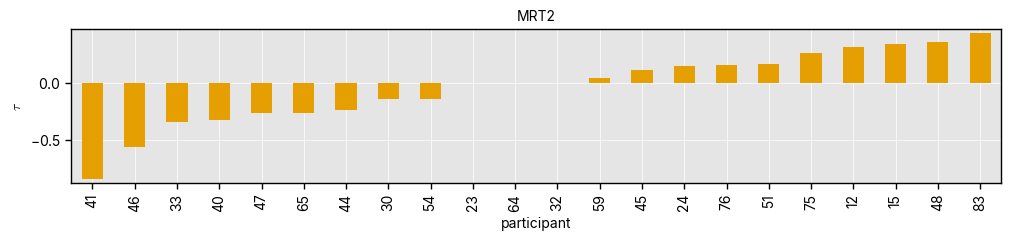

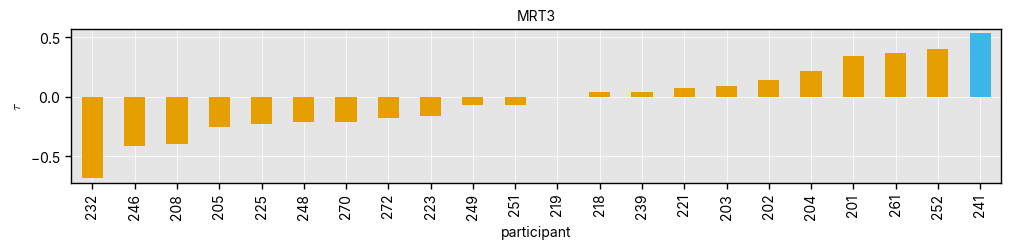

In [36]:
import sys
sys.path.append('..')
import pandas as pd
import torch as tc
from scipy.stats import kendalltau, spearmanr
import matplotlib.pyplot as plt
from plotting_styles import PaperStyle
import plotting_utils

with PaperStyle():
    
    for m, mrt in enumerate(MRT):
        fig, ax = plt.subplots(1, 1, figsize=(12,2))
        plrnn_emi_rank = plrnn_emi_cir.loc[(mrt, model, x0)]
        effects_rank = effects.loc[(mrt, binned_policy)]
        correlations = plrnn_emi_rank.corrwith(effects_rank, axis=1, method='kendall')
        available_participants = set(plrnn_emi_rank.index).intersection(set(effects_rank.index))
        significance = pd.Series([kendalltau(plrnn_emi_rank.loc[p], effects_rank.loc[p], alternative='greater').pvalue<0.05 for p in available_participants],
                             index=available_participants)
        significance.replace({True: 'C0', False: 'C1'}, inplace=True)
        participant_order = correlations.sort_values().dropna().index
        dropped = correlations.loc[correlations.isna()].index.to_list()
        if len(dropped) > 0:
            print(f'Dropped {dropped}')
        correlations.loc[participant_order].plot(ax=ax, kind='bar', ylabel=r'$\tau$', rot=90, title=f'MRT{mrt}',
                                                 color=significance.loc[participant_order])
        plotting_utils.adjust_ylim(ax, 0.03, 0.03)
        print(f'MRT{mrt}, percent >0: {100*len(correlations[correlations>0])/len(correlations)}')
        
        # plt.savefig(data_utils.join_ordinal_bptt_path('results', '_paper', f'emi_rank_correlation_mrt{mrt}.svg'))
    # plt.tight_layout()
    plt.show()

Plot the rankings according to data and models

/tmp/ipykernel_1519117/1658150744.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_1519117/1658150744.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


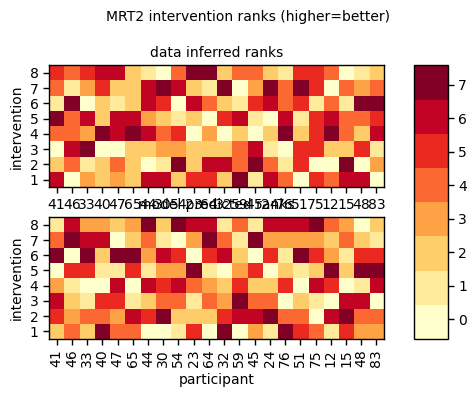

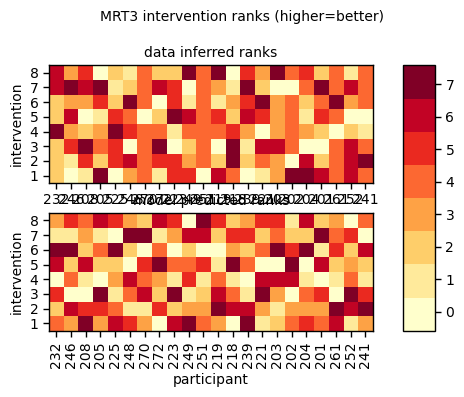

In [37]:
import matplotlib.pyplot as plt
from plotting_utils import discretized_colormap, subplots_with_colorbar
from plotting_styles import PaperStyle
import numpy as np

with PaperStyle(settings={'axes.grid':False}):
    L = len(INTERACTIVE_NAMES)
    cmap = discretized_colormap('YlOrRd', L)
    for mrt in MRT:
        plrnn_emi_rank = plrnn_emi_cir.loc[(mrt, model, x0)].rank(1)-1
        effects_rank = effects.loc[(mrt, binned_policy)].rank(1)-1
        correlations = plrnn_emi_rank.corrwith(effects_rank, axis=1, method='kendall')
        participant_order = correlations.sort_values().dropna().index
        available_participants = set(plrnn_emi_rank.index).intersection(set(effects_rank.index))
        participant_order = [p for p in participant_order if p in available_participants]

        fig, axes = subplots_with_colorbar(effects_rank.loc[participant_order].T, plrnn_emi_rank.loc[participant_order].T, nrows=2,
                                        share_all=True, cmap=cmap, aspect='equal',
                                        figsize=(12,4), cbar_ticks=np.linspace(0.5,6.5,8), cbar_ticklabels=range(L))
        
        axes[0].set_ylabel('intervention')
        axes[0].set_yticks(range(L), labels=np.arange(L)+1)
        axes[0].set_title('data inferred ranks')
        axes[0].set_xticks(ticks=range(len(participant_order)), labels=[])
        axes[1].set_ylabel('intervention')
        axes[1].set_xlabel('participant')
        axes[1].set_title('model predicted ranks')
        axes[1].set_xticks(range(len(participant_order)), labels=participant_order, rotation=90)
        fig.suptitle(f'MRT{mrt} intervention ranks (higher=better)')
        plt.tight_layout()

Plot the permutation of ranks

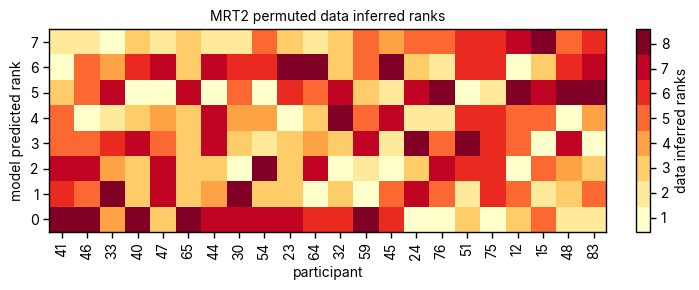

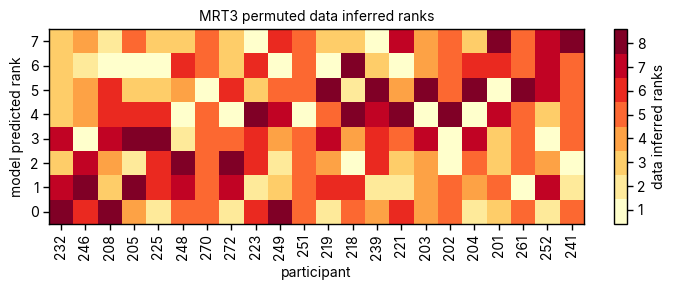

In [38]:
import matplotlib.pyplot as plt
from plotting_utils import discretized_colormap, subplots_with_colorbar
from plotting_styles import PaperStyle
import numpy as np

with PaperStyle(settings={'axes.grid':False}):
    L = len(INTERACTIVE_NAMES)
    cmap = discretized_colormap('YlOrRd', L)
    for mrt in MRT:
        plrnn_emi_rank = plrnn_emi_cir.loc[(mrt, model, x0)].rank(1)
        effects_rank = effects.loc[(mrt, binned_policy)].rank(1)
        correlations = plrnn_emi_rank.corrwith(effects_rank, axis=1, method='kendall')
        participant_order = correlations.sort_values().dropna().index
        available_participants = set(plrnn_emi_rank.index).intersection(set(effects_rank.index))
        participant_order = [p for p in participant_order if p in available_participants]
        reordered_ranks = np.zeros((len(participant_order), L))
        for j, p in enumerate(participant_order):
            reordered_ranks[j] = effects_rank.loc[p].loc[plrnn_emi_rank.loc[p].sort_values().index].to_numpy()

        fig, ax = subplots_with_colorbar(reordered_ranks.T, nrows=1, cmap=cmap, aspect='auto', axes_pad=1.5, cbar_size='2.5%',
                                        figsize=(12,3), cbar_ticks=np.linspace(1.5, L-0.5, L), cbar_ticklabels=range(1,L+1))

        ax[0].set_xlabel('participant')
        ax[0].set_ylabel('model predicted rank')
        ax[0].set_xticks(range(len(participant_order)), labels=participant_order, rotation=90)
        ax[0].set_yticks(range(L), labels=np.arange(L))
        ax[0].set_title(f'MRT{mrt} permuted data inferred ranks')
        ax[0].cax.set_ylabel('data inferred ranks')
        # for pi, p in enumerate(participants):
        #     ordered_intervs = model_ranks.loc[p].argsort().to_numpy() + 1
        #     for ii, i in enumerate(intervention_names):
        #         ax[1].annotate(str(ordered_intervs[ii]), (pi,ii))

        plt.tight_layout()
        plt.savefig(data_utils.join_ordinal_bptt_path('results', '_paper', f'permuted_ranks_mrt{mrt}.svg'))
    plt.show()

Plot both underneath each other, for both MRTs in one single plot

Dropped [14, 16, 18, 19, 21, 22, 25, 27, 31, 34, 42, 43, 52, 55, 56, 61, 63, 66, 67, 68, 69, 70, 72, 73, 74, 78, 79, 80, 82, 101, 102, 104, 206, 209, 211, 212, 214, 215, 216, 224, 226, 227, 228, 229, 230, 231, 233, 234, 237, 238, 242, 243, 247, 254, 256, 257, 258, 259, 260, 262, 263, 264, 265, 266, 267, 269, 271, 301]


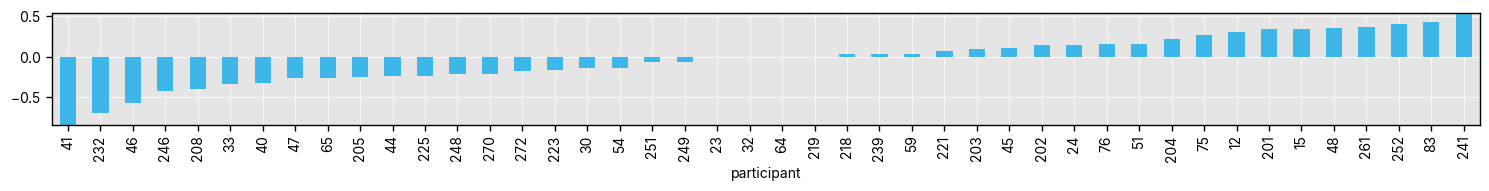

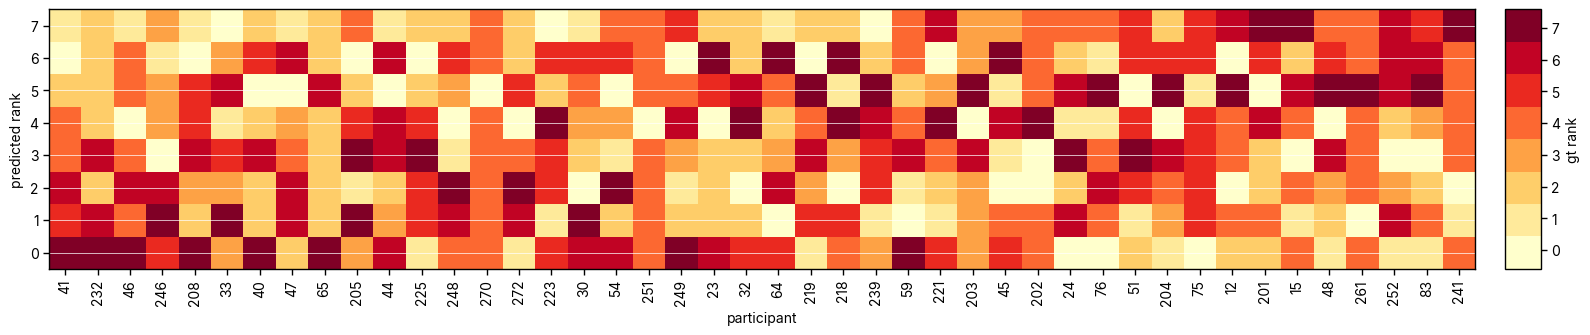

In [39]:
import sys
sys.path.append('..')
import pandas as pd
import torch as tc
import matplotlib.pyplot as plt
from plotting_styles import PaperStyle

correlations = []
with PaperStyle():
    fig, ax = plt.subplots(1, 1, figsize=(15,2))
    # for m, mrt in enumerate(MRT):
    plrnn_emi_rank = plrnn_emi_cir.loc[(pd.IndexSlice[:], model, x0), :].droplevel(['MRT', 'model', 'x0']).rank(1)-1
    effects_rank = effects.loc[(pd.IndexSlice[:], binned_policy), :].droplevel(['MRT', 'binned_policy']).rank(1)-1
    correlations.append(plrnn_emi_rank.corrwith(effects_rank, axis=1, method='kendall'))

    correlations = pd.concat(correlations, axis=0).sort_index()
    participant_order = correlations.sort_values().dropna().index

    available_participants = set(plrnn_emi_rank.index).intersection(set(effects_rank.index))
    participant_order = [p for p in participant_order if p in available_participants]

    dropped = correlations.loc[correlations.isna()].index.to_list()
    if len(dropped) > 0:
        print(f'Dropped {dropped}')
    correlations.loc[participant_order].plot(ax=ax, kind='bar', rot=90)
    plt.tight_layout()
    plt.savefig(data_utils.join_ordinal_bptt_path('results', f'_paper', 'correlation_ranks.png'), dpi=300)

    reordered_ranks = np.zeros((len(participant_order), L))
    for j, p in enumerate(participant_order):
        reordered_ranks[j] = effects_rank.loc[p].loc[plrnn_emi_rank.loc[p].sort_values().index].to_numpy()

    fig, ax = subplots_with_colorbar(reordered_ranks.T, nrows=1, cmap=cmap, aspect='auto', axes_pad=1.5, cbar_size='2.5%',
                                    figsize=(16,7), cbar_ticks=np.linspace(0.5, L-1.5, L), cbar_ticklabels=range(L))

    ax[0].set_xlabel('participant')
    ax[0].set_ylabel('predicted rank')
    ax[0].set_xticks(range(len(participant_order)), labels=participant_order, rotation=90)
    ax[0].set_yticks(range(L), labels=np.arange(L))
    ax[0].cax.set_ylabel('gt rank')

    plt.tight_layout()
    # plt.savefig(data_utils.join_ordinal_bptt_path('results', f'_paper', 'correlation_ranks_permutation.png'), dpi=300)

    plt.show()

We can also visualize this as a scatter plot between predicted and actual effect, and calculate Kendall's tau

/tmp/ipykernel_3120756/3512059504.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.corr is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tau = joint_df.groupby('participant').corr(method='kendall')['model predicted'].xs('data inferred', level=1)


Text(0.5, 0, 'participant')

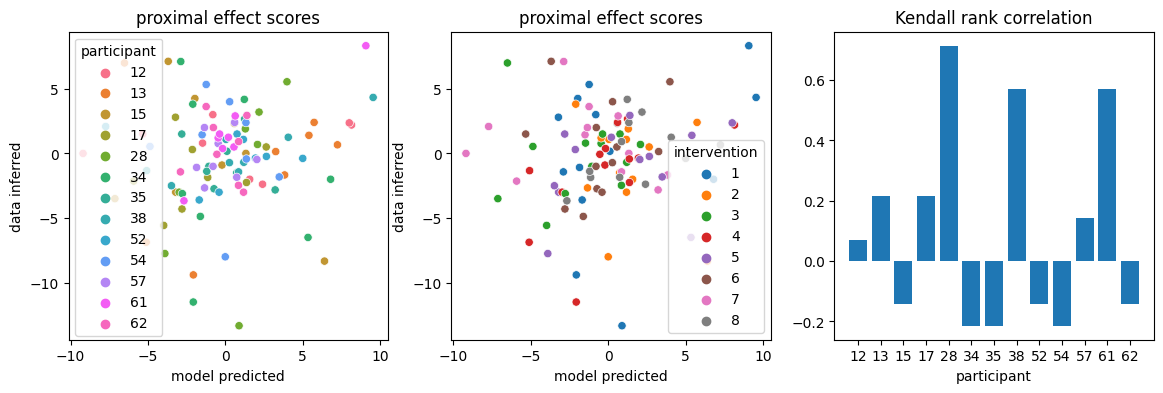

In [ ]:
import seaborn as sns
from scipy import stats

participant_effects = model_predicted_effects.copy()
for p in include_subj:
    participant_effects.loc[p] = get_proximal_effects(p, until_timestep=until_timestep[p])
joint_df = pd.concat((model_predicted_effects.stack(), participant_effects.loc[include_subj].stack()), axis=1)
joint_df = joint_df.reset_index()
joint_df.columns = ('participant', 'intervention', 'model predicted', 'data inferred')
joint_df['intervention'] = joint_df['intervention'].str.slice(-1)
tau = joint_df.groupby('participant').corr(method='kendall')['model predicted'].xs('data inferred', level=1)

fig, axes = plt.subplots(1,3, figsize=(14,4))
sns.scatterplot(data=joint_df, x='model predicted', y='data inferred', hue='participant', ax=axes[0])
axes[0].set_title('proximal effect scores')
sns.scatterplot(data=joint_df, x='model predicted', y='data inferred', hue='intervention', ax=axes[1])
axes[1].set_title('proximal effect scores')
axes[2].bar(tau.index, tau)
axes[2].set_title('Kendall rank correlation')

axes[2].set_xlabel('participant')

In [15]:
from scipy.stats import spearmanr, kendalltau
Z = np.arange(8)
r = 0
for i in range(10000):
    P = np.random.permutation(8)
    r += spearmanr(Z, P).correlation
r /= 10000
print(r)


-0.006135714285714286
